In [6]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import surprise as sp

from surprise import Reader, Dataset
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate
from surprise.model_selection import KFold
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from surprise import SVD, accuracy

import sqlite3

In [2]:
conn = sqlite3.connect('steam.db')

df = pd.read_sql_query("SELECT * FROM gameplay;", conn)

conn.close()

df = df.drop(['index'], axis = 1)
df = df.drop_duplicates()



In [3]:
app_total_playtime = df.groupby('appID').playtime.mean()
df_fix = df.join(app_total_playtime, how='left', on='appID', rsuffix='a_')
df['pt_by_app'] = df_fix.playtime /df_fix.playtimea_

user_total_playtime = df.groupby('steamID').playtime.mean()
df_fix = df.join(user_total_playtime, how='left', on = 'steamID', rsuffix='a_')
df['pt_by_user'] = df_fix.playtime / df_fix.playtimea_

df['rating'] = df['pt_by_app'] * df['pt_by_user']

In [9]:
df.head()

,steamID,appID,playtime,pt_by_app,pt_by_user,rating
0,76561198015016293,3910,1952,4.442400,1.061080,4.713742
1,76561198015016293,13230,252,0.803394,0.136984,0.110052
2,76561198015016293,12320,1137,1.530854,0.618057,0.946155
3,76561198015016293,24740,59,0.140930,0.032072,0.004520
4,76561198015016293,8980,4132,1.816186,2.246098,4.079330


In [11]:
reader = Reader()
data = Dataset.load_from_df(df[['steamID', 'appID', 'rating']], reader)

In [12]:
trainset, testset = train_test_split(data, test_size=0.25)

In [13]:
algo = SVD()
algo.fit(trainset)

In [14]:
predictions = algo.test(testset)

In [15]:
from surprise import accuracy
accuracy.rmse(predictions)

RMSE: 214.4621


214.46206151971668

In [16]:
df['rating_norm'] = (df.rating - df.rating.min()) / (df.rating.max() - df.rating.min())

In [19]:
df['rating_std'] = (df.rating - df.rating.mean()) / df.rating.std()

In [20]:
df.describe()

,appID,playtime,pt_by_app,pt_by_user,rating,rating_norm,rating_std
count,1.339385e+06,1.339385e+06,1.339385e+06,1.339385e+06,1.339385e+06,1.339385e+06,1.339385e+06
mean,2.899098e+05,1.181617e+03,1.000000e+00,1.000000e+00,6.305534e+00,6.749432e-05,-8.927377e-16
std,1.977750e+05,1.079488e+04,3.753305e+00,6.464898e+00,2.439432e+02,2.611164e-03,1.000000e+00
min,1.000000e+01,1.000000e+00,1.510186e-05,7.090117e-06,5.473670e-10,0.000000e+00,-2.584836e-02
25%,2.020900e+05,5.700000e+01,1.434969e-01,6.997471e-02,1.123392e-02,1.202476e-07,-2.580231e-02
50%,2.705500e+05,1.750000e+02,5.161122e-01,2.863810e-01,1.435862e-01,1.536944e-06,-2.525976e-02
75%,3.974600e+05,3.950000e+02,1.089913e+00,7.299112e-01,7.021475e-01,7.515774e-06,-2.297004e-02
max,1.170820e+06,1.654162e+06,8.731109e+02,2.528722e+03,9.342318e+04,1.000000e+00,3.829451e+02


(array([1.339287e+06, 6.500000e+01, 1.400000e+01, 8.000000e+00,
        5.000000e+00, 2.000000e+00, 0.000000e+00, 1.000000e+00,
        1.000000e+00, 2.000000e+00]),
 array([-2.58483647e-02,  3.82712503e+01,  7.65683490e+01,  1.14865448e+02,
         1.53162546e+02,  1.91459645e+02,  2.29756744e+02,  2.68053842e+02,
         3.06350941e+02,  3.44648040e+02,  3.82945138e+02]),
 <a list of 10 Patch objects>)

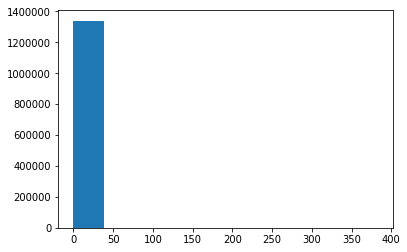

In [21]:
plt.hist(df.rating_std)

In [76]:
app_total_playtime = df.groupby('appID').playtime.mean()
df_fix = df.join(app_total_playtime, how='left', on='appID', rsuffix='a_')
df['pt_by_app'] = df_fix.playtime /df_fix.playtimea_

user_total_playtime = df.groupby('steamID').playtime.mean()
df_fix = df.join(user_total_playtime, how='left', on = 'steamID', rsuffix='a_')
df['pt_by_user'] = df_fix.playtime / df_fix.playtimea_

df['rating'] = df['pt_by_app'] * df['pt_by_user']
df['rating_fix'] = ((df.rating - df.rating.min()) / df.rating.max()) * 10.0

df['ten'] = 1 + (df.rating - df.rating.min()) * 9.0 / (df.rating.max() - df.rating.min())

In [31]:
X1 = df.groupby('appID').playtime.mean()
X2 = df.groupby('appID').playtime.max()
X3 = df.groupby('appID').playtime.min()

X4 = df.join(X1,how='left', on='appID', rsuffix='_mean')
X5 = X4.join(X2, how='left', on='appID', rsuffix='_max')
X6 = X5.join(X3, how='left', on='appID', rsuffix='_min')

df['pt_by_app_minmax'] = ((X6.playtime - X6.playtime_mean) / (X6.playtime_max - X6.playtime_min)) * 10.0

In [41]:
df['pt_by_app_mM'] = (df.pt_by_app_minmax - df.pt_by_app_minmax.min()) / df.pt_by_app_minmax.max()

In [46]:
df['tester'] = ((X6.playtime - X6.playtime_min) / (X6.playtime_max)) * 10.0

In [10]:
df['tester_rating'] = ((df.rating - df.rating.min()) / df.rating.max()) * 10.0

In [73]:
df['rating_upgrade'] = np.log10(df.rating)

/Users/Matt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


In [99]:
df['ten_upgrade'] = np.log1p(df.rating)
df['ten_fixed'] = 1 + (df.ten_upgrade - df.ten_upgrade.min()) * 9.0 / (df.ten_upgrade.max() - df.ten_upgrade.min())
df['ten_plus'] = df.ten_upgrade + abs(df.ten_upgrade.min())
df['tentwo'] = 1 + (df.ten_plus - df.ten_plus.min()) * 9.0 / (df.ten_plus.max() - df.ten_plus.min())

In [100]:
df[['rating', 'ten_upgrade','ten_fixed', 'ten_plus', 'tentwo']].describe()

,rating,ten_upgrade,ten_fixed,ten_plus,tentwo
count,1.339385e+06,1.339385e+06,1.339385e+06,1.339385e+06,1.339385e+06
mean,6.305534e+00,4.495306e-01,1.353500e+00,4.495306e-01,1.353500e+00
std,2.439432e+02,8.034900e-01,6.318453e-01,8.034900e-01,6.318453e-01
min,5.473670e-10,5.473670e-10,1.000000e+00,1.094734e-09,1.000000e+00
25%,1.123392e-02,1.117129e-02,1.008785e+00,1.117129e-02,1.008785e+00
50%,1.435862e-01,1.341692e-01,1.105507e+00,1.341692e-01,1.105507e+00
75%,7.021475e-01,5.318907e-01,1.418266e+00,5.318907e-01,1.418266e+00
max,9.342318e+04,1.144491e+01,1.000000e+01,1.144491e+01,1.000000e+01


In [74]:
df[['rating', 'rating_upgrade']].describe()

,rating,rating_upgrade
count,1.339385e+06,1.339385e+06
mean,6.749432e-04,-inf
std,2.611164e-02,NaN
min,0.000000e+00,-inf
25%,1.202476e-06,-5.919923e+00
50%,1.536944e-05,-4.813342e+00
75%,7.515774e-05,-4.124026e+00
max,1.000000e+01,1.000000e+00


(array([1.339287e+06, 6.500000e+01, 1.400000e+01, 8.000000e+00,
        5.000000e+00, 2.000000e+00, 0.000000e+00, 1.000000e+00,
        1.000000e+00, 2.000000e+00]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <a list of 10 Patch objects>)

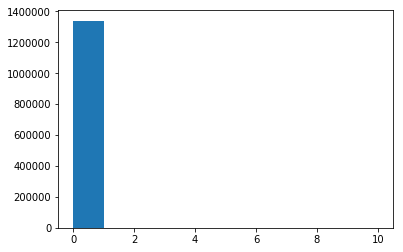

In [63]:
plt.hist(df.rating)

In [67]:
df[df.rating >= 4.0]

,steamID,appID,playtime,pt_by_app,pt_by_user,rating,rating_norm,rating_std,pt_by_app_minmax,pt_by_app_mM,tester,tester_rating
391562,76561197980090607,386940,284418,230.191022,230.388741,5.676687,0.567669,217.374810,9.956593,1.778723,9.999965,5.676687
588265,76561197972826045,72200,460681,50.649182,827.716892,4.487450,0.448745,171.830460,5.643429,1.346913,5.757075,4.487450
752759,76561198017249595,234330,807934,67.267745,1004.999319,7.236324,0.723632,277.104352,9.851353,1.768187,9.999988,7.236324
781565,76561198023692991,72200,800198,87.977091,1061.903502,10.000000,1.000000,382.945138,9.886346,1.771690,9.999988,10.000000
787714,76561198025653291,72200,521818,57.370838,1308.863007,8.037680,0.803768,307.793992,6.407453,1.423403,6.521099,8.037680
808317,76561198026779638,306130,265453,43.352400,970.135079,4.501847,0.450185,172.381818,9.769369,1.759979,9.999962,4.501847
815128,76561198030273896,91700,255835,305.179398,145.113077,4.740314,0.474031,181.514425,9.967271,1.779792,9.999961,4.740314
836888,76561198040161412,72200,599999,65.966382,702.978934,4.963755,0.496375,190.071560,7.384475,1.521217,7.498119,4.963755
915803,76561197975797010,2310,146274,237.453399,164.679310,4.185649,0.418565,160.272353,9.957955,1.778859,9.999932,4.185649
1036830,76561198122861001,698780,364185,327.038646,277.891710,9.727921,0.972792,372.525285,9.969450,1.780010,9.999973,9.727921


In [50]:
df[df.appID == 447000]

,steamID,appID,playtime,pt_by_app,pt_by_user,rating,rating_norm,rating_std,pt_by_app_minmax,pt_by_app_mM,tester
737,76561197966859246,447000,51,1.0,0.087263,0.087263,9.340607e-07,-0.025491,NaN,NaN,0.0


In [32]:
df[['pt_by_app', 'pt_by_app_minmax']].describe()

,pt_by_app,pt_by_app_minmax
count,1.339385e+06,1.335069e+06
mean,1.000000e+00,6.445156e-17
std,3.753305e+00,1.404327e+00
min,1.510186e-05,-7.810295e+00
25%,1.434969e-01,-4.254729e-01
50%,5.161122e-01,-1.359754e-01
75%,1.089913e+00,5.129949e-02
max,8.731109e+02,9.988563e+00


In [113]:
df[['rating', 'tester_rating']].describe()

,rating,tester_rating
count,1.339385e+06,1.339385e+06
mean,6.305534e+00,6.749432e-04
std,2.439432e+02,2.611164e-02
min,5.473670e-10,0.000000e+00
25%,1.123392e-02,1.202476e-06
50%,1.435862e-01,1.536944e-05
75%,7.021475e-01,7.515774e-05
max,9.342318e+04,1.000000e+01


In [114]:
reader = Reader()
data = Dataset.load_from_df(df[['steamID', 'appID', 'tester_rating']], reader)

trainset, testset = train_test_split(data, test_size=0.25)

In [115]:
algo = SVD()
algo.fit(trainset)

In [148]:
df.describe()

,appID,playtime,pt_by_app,pt_by_user,rating,rating_norm,rating_std,pt_by_app_minmax,pt_by_app_mM,tester,tester_rating,rating_upgrade,rating_fix,ten,ten_upgrade,tentwo,ten_plus,ten_fixed
count,1.339385e+06,1.339385e+06,1.339385e+06,1.339385e+06,1.339385e+06,1.339385e+06,1.339385e+06,1.335069e+06,1.335069e+06,1.339385e+06,1.339385e+06,1.339385e+06,1.339385e+06,1.339385e+06,1.339385e+06,1.339385e+06,1.339385e+06,1.339385e+06
mean,2.899098e+05,1.181617e+03,1.000000e+00,1.000000e+00,6.305534e+00,6.749432e-05,-8.927377e-16,6.445156e-17,7.819238e-01,9.768907e-01,6.749432e-04,-inf,6.749432e-04,1.000607e+00,4.495306e-01,1.353500e+00,4.495306e-01,1.353500e+00
std,1.977750e+05,1.079488e+04,3.753305e+00,6.464898e+00,2.439432e+02,2.611164e-03,1.000000e+00,1.404327e+00,1.405935e-01,1.764253e+00,2.611164e-02,NaN,2.611164e-02,2.350047e-02,8.034900e-01,6.318453e-01,8.034900e-01,6.318453e-01
min,1.000000e+01,1.000000e+00,1.510186e-05,7.090117e-06,5.473670e-10,0.000000e+00,-2.584836e-02,-7.810295e+00,0.000000e+00,0.000000e+00,0.000000e+00,-inf,0.000000e+00,1.000000e+00,5.473670e-10,1.000000e+00,1.094734e-09,1.000000e+00
25%,2.020900e+05,5.700000e+01,1.434969e-01,6.997471e-02,1.123392e-02,1.202476e-07,-2.580231e-02,-4.254729e-01,7.393278e-01,3.376871e-02,1.202476e-06,-5.919923e+00,1.202476e-06,1.000001e+00,1.117129e-02,1.008785e+00,1.117129e-02,1.008785e+00
50%,2.705500e+05,1.750000e+02,5.161122e-01,2.863810e-01,1.435862e-01,1.536944e-06,-2.525976e-02,-1.359754e-01,7.683107e-01,2.392947e-01,1.536944e-05,-4.813342e+00,1.536944e-05,1.000014e+00,1.341692e-01,1.105507e+00,1.341692e-01,1.105507e+00
75%,3.974600e+05,3.950000e+02,1.089913e+00,7.299112e-01,7.021475e-01,7.515774e-06,-2.297004e-02,5.129949e-02,7.870596e-01,1.078977e+00,7.515774e-05,-4.124026e+00,7.515774e-05,1.000068e+00,5.318907e-01,1.418266e+00,5.318907e-01,1.418266e+00
max,1.170820e+06,1.654162e+06,8.731109e+02,2.528722e+03,9.342318e+04,1.000000e+00,3.829451e+02,9.988563e+00,1.781924e+00,9.999994e+00,1.000000e+01,1.000000e+00,1.000000e+01,1.000000e+01,1.144491e+01,1.000000e+01,1.144491e+01,1.000000e+01


In [116]:
predictions = algo.test(testset)

In [117]:
accuracy.rmse(predictions)

RMSE: 0.9996


0.9996253289852056

In [118]:
predictions

[Prediction(uid='76561197975710309', iid=467000, r_ui=9.936499073643436e-06, est=1, details={'was_impossible': False}),
 Prediction(uid='76561198019466684', iid=310060, r_ui=6.440963332838743e-05, est=1, details={'was_impossible': False}),
 Prediction(uid='76561198036405900', iid=263760, r_ui=9.069441845050571e-05, est=1, details={'was_impossible': False}),
 Prediction(uid='76561198009337917', iid=224260, r_ui=7.153519006317562e-05, est=1, details={'was_impossible': False}),
 Prediction(uid='76561197982710309', iid=224580, r_ui=1.6108978995942575e-07, est=1, details={'was_impossible': False}),
 Prediction(uid='76561198027076339', iid=35720, r_ui=3.233672139265619e-06, est=1, details={'was_impossible': False}),
 Prediction(uid='76561198039302883', iid=289070, r_ui=0.000452719955746111, est=1, details={'was_impossible': False}),
 Prediction(uid='76561198020324256', iid=219640, r_ui=0.00023343432748579592, est=1, details={'was_impossible': False}),
 Prediction(uid='76561198001457487', iid

In [120]:
predicted_rating = algo.predict(str(76561198025901072), str(28050))

In [121]:
print(predicted_rating)

user: 76561198025901072 item: 28050      r_ui = None   est = 1.00   {'was_impossible': False}


In [159]:
def algo_tester(data_object):
    benchmark = []
    # sp.SVDpp(),
    algos = [sp.SVD(), sp.SlopeOne(), sp.NMF(), sp.NormalPredictor(), sp.KNNBaseline(), sp.KNNBasic(), sp.KNNWithMeans(), sp.KNNWithZScore(), sp.BaselineOnly(), sp.CoClustering()]

    # Iterate over all algorithms
    for algorithm in algos:
    # Perform cross validation
        results = cross_validate(algorithm, data_object, measures=['RMSE'], cv=3, verbose=False)

    # Get results & append algorithm name
        tmp = pd.DataFrame.from_dict(results).mean(axis=0)
        tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
        benchmark.append(tmp)
        print(benchmark)
    benchmark= pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')

    return benchmark

In [128]:
reader = Reader()
data = Dataset.load_from_df(df[['steamID', 'appID', 'tester_rating']], reader)

In [17]:
reader = Reader(rating_scale = (0, 10))
data = Dataset.load_from_df(df[['steamID', 'appID', 'fixfix']], reader)

trainset, testset = train_test_split(data, test_size=0.25)

In [18]:
algo = sp.SVD()
algo.fit(trainset)
predictions = algo.test(testset)
accuracy.rmse(predictions)

RMSE: 3.7132


3.713232049863726

In [19]:
predictions

[Prediction(uid='76561197991853435', iid=35720, r_ui=2.142857142857143, est=1.9336195542624506, details={'was_impossible': False}),
 Prediction(uid='76561197989047881', iid=34220, r_ui=1.5209230429502043, est=2.8540915234143442, details={'was_impossible': False}),
 Prediction(uid='76561198002590465', iid=1085660, r_ui=1.8617021276595744, est=2.080997524524201, details={'was_impossible': False}),
 Prediction(uid='76561198037773308', iid=252490, r_ui=0.9421560035056968, est=2.2068922543332334, details={'was_impossible': False}),
 Prediction(uid='76561197984328010', iid=391540, r_ui=1.3256484149855907, est=7.609921580242563, details={'was_impossible': False}),
 Prediction(uid='76561198078967474', iid=729040, r_ui=0.6122448979591837, est=8.440037395588146, details={'was_impossible': False}),
 Prediction(uid='76561197993619847', iid=80330, r_ui=10.0, est=4.0946417536712465, details={'was_impossible': False}),
 Prediction(uid='76561198067261759', iid=452860, r_ui=10.0, est=6.180999969502301,

In [14]:
df.head()

,steamID,appID,playtime,pt_by_app,pt_by_user,rating,tester_rating
0,76561198015016293,3910,1952,4.442400,1.061080,4.713742,5.045581e-04
1,76561198015016293,13230,252,0.803394,0.136984,0.110052,1.177994e-05
2,76561198015016293,12320,1137,1.530854,0.618057,0.946155,1.012763e-04
3,76561198015016293,24740,59,0.140930,0.032072,0.004520,4.838029e-07
4,76561198015016293,8980,4132,1.816186,2.246098,4.079330,4.366508e-04


In [15]:
atp = df.groupby('appID').playtime.median()
df_fix = df.join(atp, how='left', on='appID', rsuffix='_m')
df['fixfix'] = (df_fix.playtime / df_fix.playtime_m) * 5.0
df.loc[df.fixfix > 10, 'fixfix'] = 10

(array([197975., 110220., 116133., 111503., 144959., 115095.,  77343.,
         57462.,  44289., 364406.]),
 array([2.59598660e-04, 1.00023364e+00, 2.00020768e+00, 3.00018172e+00,
        4.00015576e+00, 5.00012980e+00, 6.00010384e+00, 7.00007788e+00,
        8.00005192e+00, 9.00002596e+00, 1.00000000e+01]),
 <a list of 10 Patch objects>)

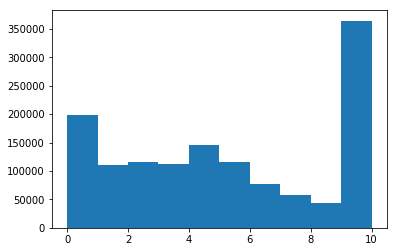

In [22]:
plt.hist(df.fixfix)